# Challenge
### Reshape the blended Laplacian such that the 'spsolve' function only runs once instead of three times.

First we see the image blending process that solves for three color layers and combines them to output the blended image.

In [1]:
#Import Packages

%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import torch
import kornia
import scipy.sparse
import os

from kornia.filters import laplacian
from torchvision import datasets, transforms
from scipy.sparse.linalg import spsolve, cg

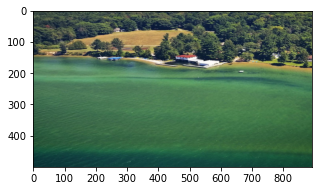

In [2]:
# specify kernel size
ker_size = 3


lakehouse = plt.imread('rex2.jpg')
lakehouse = lakehouse / lakehouse.max()
plt.figure(figsize = (5,5))
plt.imshow(lakehouse)

In [3]:
lakehouse.shape

(500, 893, 3)

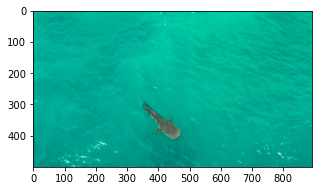

In [4]:
whale = plt.imread('bluewhale.jpg')
whale = whale / whale.max()
plt.figure(figsize = (5,5))
plt.imshow(whale)

In [5]:
whale.shape

(500, 893, 3)

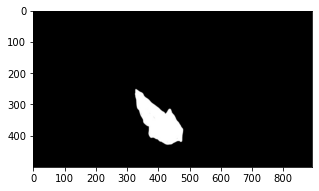

In [6]:
mask = plt.imread('bluewhalemask.jpg')
mask = mask / mask.max()
plt.figure(figsize = (5,5))
plt.imshow(mask)

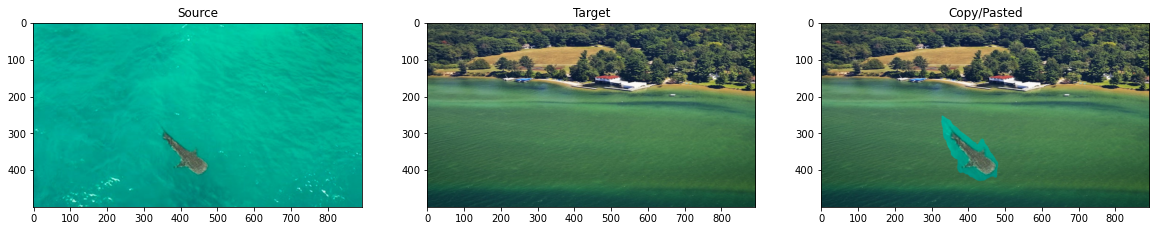

In [7]:
blendpic = (1-mask)*lakehouse + (mask)*whale
fig,ax = plt.subplots(1,3,figsize = (20,20))
ax[0].imshow(whale)
ax[0].set_title('Source')
ax[1].imshow(lakehouse)
ax[1].set_title('Target');
ax[2].imshow(blendpic)
ax[2].set_title('Copy/Pasted');

In [8]:
# create a transform to transform the images to tensors
to_tensor = transforms.ToTensor()

In [9]:
# 'Unsqueeze' the image tensor to fit to the kornia filter's dimension requirements BxCxHxW
source = torch.unsqueeze(to_tensor(whale), dim=0)

# 'Unsqueeze' the image tensor to fit to the kornia filter's dimension requirements BxCxHxW
target = torch.unsqueeze(to_tensor(lakehouse), dim=0)

# Check shape of tensor
source.shape, target.shape

(torch.Size([1, 3, 500, 893]), torch.Size([1, 3, 500, 893]))

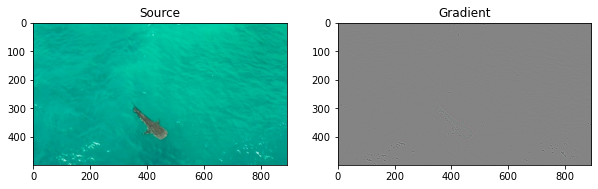

In [10]:
# take the laplacian of the tensor using a 3x3 kernel size
lapsource = laplacian(source, ker_size)
# convert the tensor back to image
imagelapsource = kornia.tensor_to_image(lapsource)
# take the laplacian of the tensor using a 3x3 kernel size
laptarget = laplacian(target, ker_size)
# convert the tensor back to image
imagelaptarget = kornia.tensor_to_image(laptarget)


# example output
fig,ax = plt.subplots(1,2,figsize = (10,20))
ax[0].imshow(whale)
ax[0].set_title('Source')
ax[1].imshow((imagelapsource - imagelapsource.min())/(imagelapsource.max() - imagelapsource.min()))
ax[1].set_title('Gradient');

In [11]:
# mixes the whale of the source with everything but the whale area of the target
blend_lap = (1-mask)*imagelaptarget + mask*imagelapsource

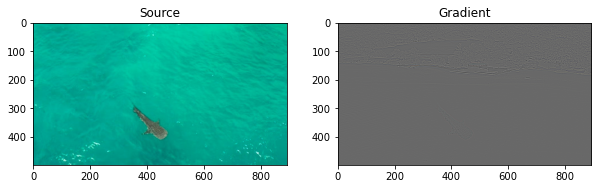

In [12]:
fig,ax = plt.subplots(1,2,figsize = (10,20))
ax[0].imshow(whale)
ax[0].set_title('Source')
ax[1].imshow((blend_lap - blend_lap.min())/(blend_lap.max() - blend_lap.min()))
ax[1].set_title('Gradient');

In [29]:
import scipy.sparse

# Creates a laplacian matrix function
def laplacian_matrix(n, m):   
    mat_D = scipy.sparse.lil_matrix((m, m), dtype = int)
    mat_D.setdiag(-1, -1)
    mat_D.setdiag(8)
    mat_D.setdiag(-1, 1)
        
    mat_A = scipy.sparse.block_diag([mat_D] * n, dtype = int).tolil()
    
    mat_A.setdiag(-1,  1*m)
    mat_A.setdiag(-1, -1*m)
    mat_A.setdiag(-1,  1*m+1)
    mat_A.setdiag(-1, -1*m+1)
    mat_A.setdiag(-1,  1*m-1)
    mat_A.setdiag(-1, -1*m-1)
    
    return mat_A

#sample output
sample3 = laplacian_matrix(500, 893)
sample3

<446500x446500 sparse matrix of type '<class 'numpy.int64'>'
	with 4012142 stored elements in List of Lists format>

In [24]:
blend_lap.shape[:-1]

(500, 893)

In [28]:
laplacian_matrix( *blend_lap.shape[:-1] )

<446500x446500 sparse matrix of type '<class 'numpy.int64'>'
	with 4012142 stored elements in List of Lists format>

In [26]:
mat_A2 = laplacian_matrix( *blend_lap.shape[:-1] ).tocsc()
mat_A2

<446500x446500 sparse matrix of type '<class 'numpy.int64'>'
	with 4012142 stored elements in Compressed Sparse Column format>

In [14]:
from scipy.sparse.linalg import spsolve, cg

mat_A2 = laplacian_matrix( *blend_lap.shape[:-1] ).tocsc()
# tocsc() converts matrix to Compressed Sparse Column format

# solve for each level of the three color values (RGB)
ImgChans = []
for i in range(3):
    mat_b = blend_lap[:,:,i].flatten()
    ImgChans.append( spsolve(mat_A2, mat_b) )
    print(i)

0
1
2


In [30]:
# blends three images into one
Blendedfinal = np.stack( [ img.reshape(blend_lap.shape[:-1]) for img in ImgChans], axis = 2)
Blendedfinal.shape

(500, 893, 3)

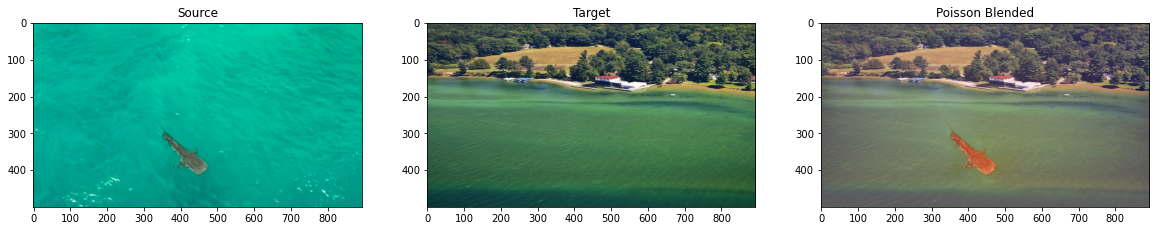

In [16]:
Blendedfinal = 1 - (Blendedfinal - Blendedfinal.min())/(Blendedfinal.max() - Blendedfinal.min())

fig,ax = plt.subplots(1,3,figsize = (20,20))
ax[0].imshow(whale)
ax[0].set_title('Source')
ax[1].imshow(lakehouse)
ax[1].set_title('Target');
ax[2].imshow(Blendedfinal)
ax[2].set_title('Poisson Blended');

# New Work

## The whale is blended into the lake, but the color is so distorted that the whale looks red. This is the result of solving the three color layers separately.

The laplacian matrix for this example is quite large as, given an input of $m\times n$, the result is a laplacian matrix of size $(mn)\times(mn)$. The source and target images are size $893\times 500$ pixels meaning the laplacian matrix $A$ is size $446500\times 446500$. Furthermorem, matrix $b$ is flattened to a one-dimensional array of size $446500$. Thus, we have the system $$ Ax=b $$ comprised of very large matrices.

Instead of running the code above that solves for each layer, we reshape our blended laplacian matrix to $446500\times 3$ and only use the 'spsolve' function once instead of three times.

In [17]:
blend_lap2 = blend_lap.reshape(446500,3)

In [18]:
output1 = spsolve(mat_A2,blend_lap2)

Now we just reshape the blended image to the original size. 

In [19]:
output2 = output1.reshape(500,893,3)

In [20]:
output2.shape

(500, 893, 3)

The code is much simpler, and the output seems to be identical to the first method.

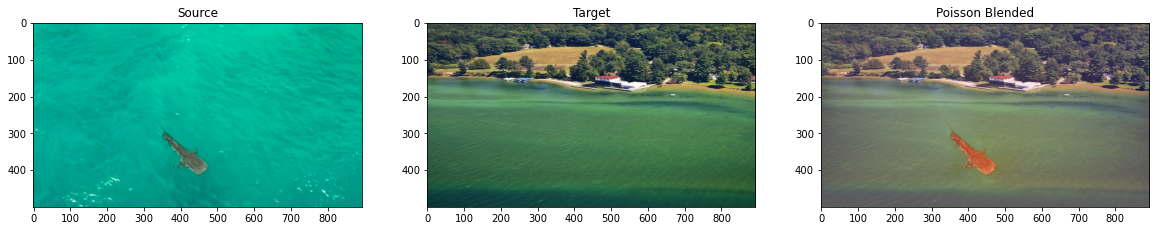

In [21]:
Blendedfinal2 = 1 - (output2 - output2.min())/(output2.max() - output2.min())

fig,ax = plt.subplots(1,3,figsize = (20,20))
ax[0].imshow(whale)
ax[0].set_title('Source')
ax[1].imshow(lakehouse)
ax[1].set_title('Target');
ax[2].imshow(Blendedfinal2)
ax[2].set_title('Poisson Blended');

# Possible frame detection?

In [23]:
"""
 * Python program to use skimage drawing tools to create a mask.
 *
"""
import skimage
from skimage.viewer import ImageViewer
import numpy as np

# Load and display the original image
image = skimage.io.imread("maize-roots.tif")
viewer = ImageViewer(image)
viewer.show()

/Users/MansfieldsMac/opt/anaconda3/lib/python3.7/site-packages/skimage/viewer/utils/__init__.py:1: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  from .core import *


FileNotFoundError: [Errno 2] No such file or directory: '/Users/MansfieldsMac/Desktop/Thesis/ThesisCode/maize-roots.tif'

In [ ]:
# Create the basic mask
mask = np.ones(shape=image.shape[0:2], dtype="bool")

In [ ]:
# Draw filled rectangle on the mask image
rr, cc = skimage.draw.rectangle(start=(357, 44), end=(740, 720))
mask[rr, cc] = False

In [ ]:
# Display constructed mask
viewer = ImageViewer(mask)
viewer.show()

In [ ]:
### https://datacarpentry.org/image-processing/04-drawing/